# SMS Spam Classification

## Fundamentals of Data Science - Final Project

Simone Boesso, Davide Cacciatore, Giulio Corsetti, Francesca Possenti, Letizia Russo

In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
import string
import math

from matplotlib.colors import ListedColormap
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

## Phase 0 : Exploratory Data Analysis

In [2]:
# Load the data
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# We drop the redundent looking columns
unuseful = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
df = df.drop(df[unuseful], axis=1)

# We rename the columns in order to make them more understandable
df.rename(columns = {"v1": "Target", "v2": "Text"}, inplace = True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Show an ham and a spam sms
print(df['Text'][10])
print(df['Text'][8])

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.


Barplot of the two different classes. Taken from [here](https://www.kaggle.com/karnikakapoor/spam-or-ham-sms-classifier)

Ham: 4825 
Spam: 747


Text(0, 0.5, 'Number of Data points')

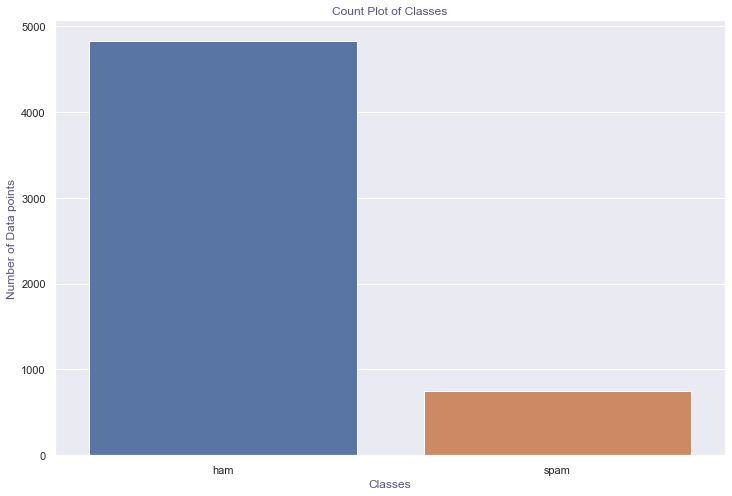

In [5]:
sns.set_theme()
print('Ham:', len(df[df['Target'] == 'ham']), '\nSpam:', len(df[df['Target'] == 'spam']))

plt.figure(figsize=(12,8))
fg = sns.countplot(x = df["Target"])
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [6]:
#Adding a column of numbers of charachters, words and sentences in each msg
df["No_of_Characters"] = df["Text"].apply(len)
df["No_of_Words"] = df.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
df["No_of_sentence"] = df.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.698492,13.737477,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.991565,1.501427,1.0,1.0,1.5,2.0,38.0


<Figure size 864x576 with 0 Axes>

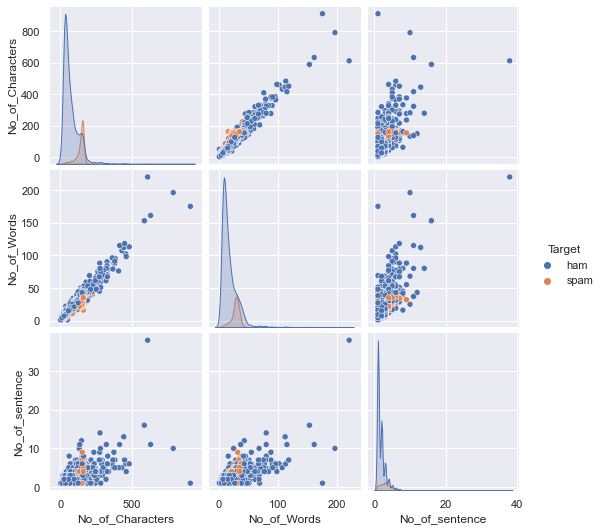

In [7]:
# Plot the number of characters, of words and of sentences for the ham and the spam messages
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="Target")
plt.show(fg)

# Phase 1: Data Preprocessing

In order to further process the data, we need to make the data cleaner.

In the first step we extract only the alphabetic characters, so we remove punctuation and numbers. Then we convert all the characters into lowercase.

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dcacc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Pre-process a text : clean, tokenize and stem each word in text
def pre_processing(text):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Removing punctuation, lowercase the text, removing stopwords, map punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    p_text = text.translate(translator).lower()
    ppt = ""
    
    for word in p_text.split():
        if word not in stopwords.words('english'):
            ppt += word + " "
    text = ppt.strip(" ")
    token_words = word_tokenize(text)
    lem_sentence = []
    
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word, pos ='v'))
    return ' '.join(lem_sentence)

df["Pre_processed_text"] = df["Text"].apply(pre_processing)

In [10]:
# It creates a set for all the words
bag_words = set()
for sms in df["Pre_processed_text"]:
    for w in sms.split(" "):
        if w != "":
            bag_words = bag_words.union({w})

# Create a list of the words <- our corpus of words
bag = list(bag_words)

In [11]:
# It returns a list of words for each sms
def split_words(text, bag_words):
    return text.split(" ")

In [12]:
df["Words"] = df["Pre_processed_text"].apply(split_words, args = (bag_words,))

In [13]:
bag_len = len(bag) # Number of words in the bag # Size of the corpus

# Vectorize each sms, assign 1 every time a specific word is in the sms
def vectorize_sms(words):
    vector = np.zeros(bag_len, dtype = "int64")    
    for i in range(bag_len):
        if bag[i] in words:
            vector[i] += 1            
    return vector

In [14]:
df["Vector"] = df["Words"].apply(vectorize_sms)
df 

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Pre_processed_text,Words,Vector
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think go usf live around though,"[nah, think, go, usf, live, around, though]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time try 2 contact u u å£750 pound prize 2...,"[2nd, time, try, 2, contact, u, u, å£750, poun...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,ì b go esplanade fr home,"[ì, b, go, esplanade, fr, home]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,pity mood suggestions,"[pity, mood, suggestions]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy something else...,"[guy, bitch, act, like, interest, buy, somethi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Create a dataframe ready for the analysis. It has the sms (documents) on the row and the words (features) on the columns. 
This dataframe counts the words in the sms.

In [15]:
# Initialize the dataframe
X = np.zeros((len(df), bag_len), dtype = "int64")

# For each sms consider its vectorized form
for i in range(len(df)):
    X[i] += df.iloc[i, 7]
    
# Create a pandas Dataframe    
pd.DataFrame(X, columns = bag)

,supply,aquarius,87077,97n7qp,stereo,ben,message,å£54,cedar,tonexs,...,errors,08717205546,pobox84,event,outsider,curfew,danger,anyhow,chest,nights
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Create the classes encoding the 'spam' and 'ham' information
'''
If a sms is ham == 0;
if a sms is spam == 1
'''

y = np.zeros(len(df), dtype="int64")

for i in range(len(df["Target"])):
    if df.iloc[i,0] == "ham":
        y[i] = 0
    else:
        y[i] = 1

# Phase 2: Naive Bayes

In [17]:
# Splitting the test and training set
# We decided to consider the 20% of the dataset as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape

((4457, 7644), (4457,))

In [18]:
# Fit the train data into the model and then use it to predict the test data
nb = MultinomialNB()
nb.fit(X_train, y_train)

pred = nb.predict(X_test)
probs = nb.predict_proba(X_test)

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, pred)
cm

array([[955,  10],
       [ 12, 138]], dtype=int64)

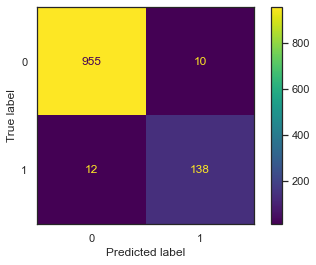

In [20]:
# Plot the confusion matrix
sns.set_theme(style="white")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [21]:
# Plot the ROC curve
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])

In [22]:
# Compute the AUC
auc(fpr, tpr)

0.9860932642487047

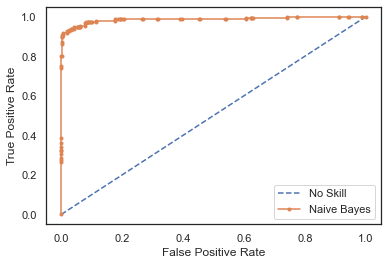

In [23]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

*True Positive Rate* and *False Positive Rate* given by the default threshold.

In [24]:
true_positive = cm[0,0]
false_negative = cm[1,0]
false_positive = cm[0,1]
true_negative = cm[1,1]

true_positive_Rate = true_positive / (true_positive + false_negative)
false_positive_Rate = false_positive / (false_positive + true_negative)

print("true positive Rate", true_positive_Rate)
print("false positive Rate", false_positive_Rate)

true positive Rate 0.9875904860392968
false positive Rate 0.06756756756756757


*True Positive Rate* and *False Positive Rate* looking for the threshold that optimizes *TPR - FPR*.

In [25]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print("Threshold value is:", optimal_threshold)
print("TPR ",tpr[optimal_idx])
print("FPR ",fpr[optimal_idx])

Threshold value is: 0.758057507058877
TPR  0.92
FPR  0.0051813471502590676


Confusion matrix using this new threshold.

In [26]:
threshold = 0.758057507058877
good = probs[:, 1]
predicted_good = good > threshold
cm = confusion_matrix(y_test, predicted_good)
cm

array([[960,   5],
       [ 13, 137]], dtype=int64)

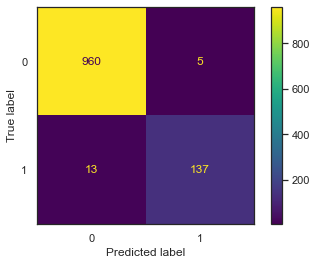

In [27]:
sns.set_theme(style="white")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## Phase 3: Compare with LogisticRegression

In [28]:
#Testing with Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
probs_lr = lr.predict_proba(X_test)

In [29]:
fpr, tpr, threshold = roc_curve(y_test, probs_lr[:,1])

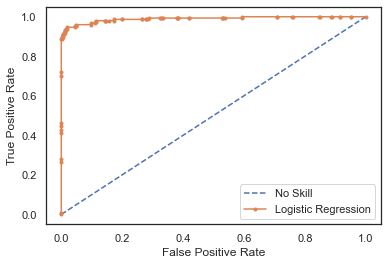

In [30]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [31]:
auc(fpr, tpr)

0.9896442141623488

Confusion matrix

In [41]:
cm = confusion_matrix(y_test, pred_lr)
cm

array([[965,   0],
       [ 27, 123]], dtype=int64)

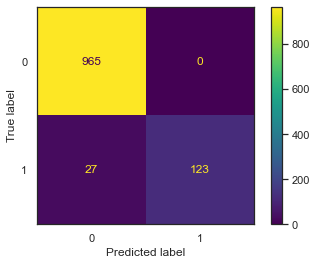

In [42]:
sns.set_theme(style="white")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## Phase 4: Mis-predicted SMS

Analysing the mis-predicted sms.

In [34]:
# Find the indexes ( in the test set ) for the mis-predicted sms
miss = pred != y_test
np.nonzero(miss)

(array([  21,   58,  161,  225,  268,  299,  319,  397,  522,  652,  669,
         701,  780,  781,  786,  843,  892,  918,  922,  946, 1031, 1066],
       dtype=int64),)

Select SMS 319

In [35]:
# How it is predicted?
pred[319]

1

In [36]:
# How it is labeled in the dataframe?
y_test[319]

0

It is predicted as spam but it is ham.

In [37]:
# Find the original sms text
idx = 0
for i in df['Vector']:
    comparison = i == X_test[319]
    equal_arrays = comparison.all()
    if equal_arrays == True:
        print(df['Text'][idx])
    idx += 1

Total video converter free download type this in google search:)


Select SMS 1066

In [38]:
# How it is predicted?
pred[1066]

0

In [39]:
# How it is labeled in the dataframe?
y_test[1066]

1

It's predicted as ham but it's spam.

In [40]:
# Find the original sms text
idx = 0
for i in df['Vector']:
    comparison = i == X_test[1066]
    equal_arrays = comparison.all()
    if equal_arrays == True:
        print(df['Text'][idx])
    idx += 1

Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?
